In [17]:

import matplotlib.pyplot as plt
import snntorch.functional as sf
import snntorch as snn
from snntorch import spikegen
import torch, torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

In [18]:
class Net(nn.Module):
    '''Spiking Neural network'''
    def __init__(self, num_inputs, num_hiddens, num_outputs, beta):
        super().__init__()

        self.num_inputs = num_inputs # number of inputs
        self.num_hidden = num_hiddens # number of hidden neurons
        self.num_outputs = num_outputs # number of output neurons

        # initialize layers
        self.fc1 = nn.Linear(self.num_inputs, self.num_hidden) # connection input and hidden layer
        self.lif1 = snn.Leaky(beta=beta) # hidden layer
        self.fc2 = nn.Linear(self.num_hidden, self.num_outputs) # connection hidden layer and output
        self.lif2 = snn.Leaky(beta=beta) # output layer

    def forward(self, data, num_steps):
        '''Run the network for ``num_steps`` with ``data`` as input. Output spiketrains of outputs'''
        # initialize membrane potentials for hidden and output layer
        mem_hid = self.lif1.init_leaky()
        mem_out = self.lif1.init_leaky()

        spike_out_rec = []

        for i in range(num_steps):
            input = self.fc1(data[i])
            spike_hid, mem_hid = self.lif1(input, mem_hid)
            hidden_out = self.fc2(spike_hid)
            spike_out, mem_out = self.lif2(hidden_out, mem_out)

            spike_out_rec.append(spike_out)

        return torch.stack(spike_out_rec)

In [19]:

def import_data():
    # Define a transform
    transform = transforms.Compose([
                transforms.Resize((28,28)),
                transforms.Grayscale(),
                transforms.ToTensor(),
                transforms.Normalize((0,), (1,))])

    mnist_train = datasets.MNIST("/dataset/", train=True, download=True, transform=transform)
    mnist_test = datasets.MNIST("/dataset/", train=False, download=True, transform=transform)

    train_loader = DataLoader(mnist_train, batch_size=128)
    test_loader = DataLoader(mnist_test, batch_size=128)


    return train_loader, test_loader


In [20]:

# rate encode pixels to binary representation for input trains
def gen_spike_trains(data, n_steps):
    ''' Generate spike train
        In: [num_steps, batch, input_size]
        Out: [num_steps, batch, input_size]
    '''
    spike_data = spikegen.rate(data.flatten(1), num_steps=n_steps)
    return spike_data


In [21]:

def plot_accuracy(acc_hist, title):
    %matplotlib inline
    fig = plt.figure(facecolor="w")
    plt.plot(acc_hist)
    plt.title(title)
    plt.xlabel("Measurement")
    plt.ylabel("Accuracy")
    # plt.savefig(title+".png")
    plt.show()

def plot_loss(loss_hist, title):
    %matplotlib inline
    fig = plt.figure(facecolor="w")
    plt.plot(loss_hist)
    plt.title(title)
    plt.xlabel("Measurement")
    plt.ylabel("Loss")
    # plt.savefig(title+".png")
    plt.show()


In [22]:

def test_accuracy(data_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    data_loader = iter(data_loader)
    for data, targets in data_loader:
      input = gen_spike_trains(data, num_steps)
      spk_rec = net(input, num_steps)

      acc += sf.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total


In [23]:

# TODO: take inhibitionary neuronal spikes into account?
def train_snn(net:Net, optimizer:torch.optim.Adam, loss_fn:sf.mse_count_loss, train_loader, n_steps):
    '''Training loop for snn'''

    epochs = 1
    acc_hist = []
    loss_hist = []

    for epoch in range(epochs):
        # for i, (data, label) in enumerate(tqdm(iter(train_loader))):
        with tqdm(train_loader, unit="batch") as tqepch:
            tqepch.set_description(desc=f"Epoch {epoch}")
            for i, (data, label) in enumerate(tqepch):
                # convert input to spike trains
                input = gen_spike_trains(data.squeeze(), n_steps)

                # set net to training mode
                net.train()

                # do forward pass
                output = net(input, n_steps)

                # calculate loss value
                loss_val = loss_fn(output, label)
                loss_hist.append(loss_val.item())

                # clear previously stored gradients
                optimizer.zero_grad()

                # calculate the gradients
                loss_val.backward()

                # weight update
                optimizer.step()

                acc = sf.accuracy_rate(output, label)
                acc_hist.append(acc)
                tqepch.set_postfix(loss=loss_val.item(), accuracy=100.00 * acc)

    plot_accuracy(acc_hist, "Train accuracy")
    plot_loss(loss_hist, "Train loss")

    # return output spike train
    return net


In [24]:

# number of time steps
n_steps = 25 #ms

# neuron counts
inputs = 28 * 28
hiddens = 200
outputs = 10

# import training data
train_loader, test_loader = import_data()

# potential decay
decay = 0.9

# initialize net
net = Net(inputs, hiddens, outputs, decay)

# optimalizatie algoritme
optimizer = torch.optim.Adam(net.parameters()) # (NOTE: Adam stond in de tutorial wellicht beter algo)

# loss function
loss_fn = sf.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2) # type: ignore


Epoch 0: 100%|██████████| 469/469 [00:59<00:00,  7.82batch/s, accuracy=97.9, loss=0.11]  


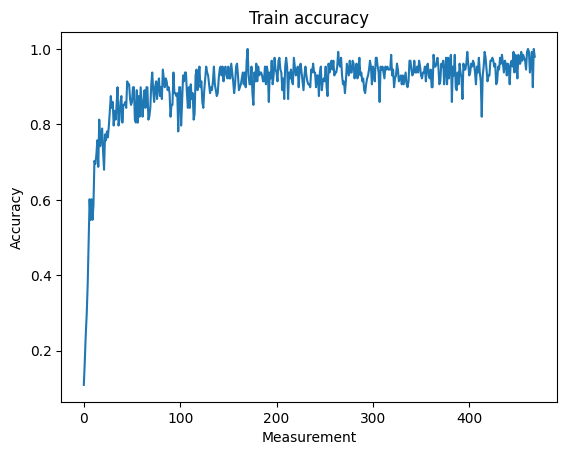

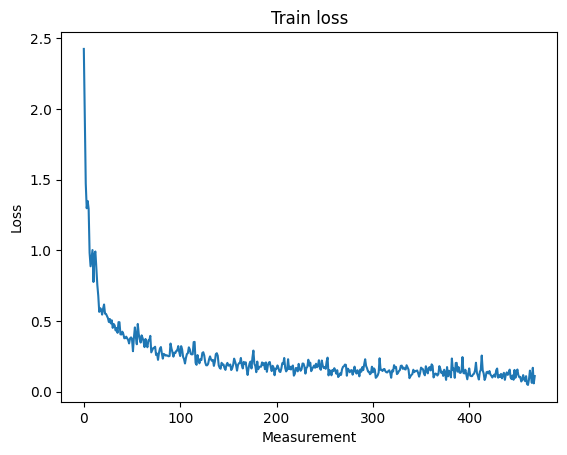

Test accuracy: 94.70%


In [25]:

trained_net = train_snn(net, optimizer, loss_fn, train_loader, n_steps)


print(f'Test accuracy: {test_accuracy(test_loader, trained_net, n_steps) * 100:.2f}%')
